# Pytorch "Standard"

## Dataset Creation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import sys
from tqdm.notebook import tqdm
sys.path.append("../")
import torch
from monai.transforms import (
    Activations,
    AsChannelFirst,
    AsDiscrete,
    Compose,
    RandFlip,
    RandRotate,
    RandZoom,
    Resize,ToTensor
)
# from torch.utils.data import DataLoader
from monai.data import DataLoader,decollate_batch
from monai.networks.nets import DenseNet121
from sklearn.model_selection import train_test_split
from monai.metrics import ROCAUCMetric
from monai.utils import set_determinism


In [2]:
set_determinism(seed=0)
T1  = ["/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/T1/" + x for x in os.listdir("/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/T1/")]
T2  = ["/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/T2/" + x for x in os.listdir("/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/T2/")]
FLAIR  = ["/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/FLAIR/" + x for x in os.listdir("/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/FLAIR/")]
OTHER  = ["/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/OTHER/" + x for x in os.listdir("/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/OTHER/")]


X = T1 + T2 + FLAIR +OTHER 
y = list(np.zeros(len(T1),dtype = int)) + list(np.ones(len(T2),dtype = int)) + list(2*np.ones(len(FLAIR),dtype = int)) + list(3*np.ones(len(OTHER),dtype = int))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True ,random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,shuffle=True ,random_state=42,stratify=y_train)

print("Le dimensioni del dataset sono : ")
print(f"Train {len(X_train)}")
print(f"Validation {len(X_val)}")
print(f"Test {len(X_test)}")


Le dimensioni del dataset sono : 
Train 1129
Validation 283
Test 353


In [3]:
class Sequence_Dataset(torch.utils.data.Dataset) : 
    def __init__(self,image_files, transforms): 
        self.image_files = image_files
        self.transforms = transforms
    def __len__(self):
        return len(self.image_files)
    
    
    def __getitem__(self,index) :
        img = np.load(self.image_files[index])
        label = os.path.basename(os.path.dirname(self.image_files[index]))
        if label == "T1" :
            L = 0
        elif label == "T2":
            L =1 
        elif label == "FLAIR" : 
            L = 2
        elif label == "OTHER" : 
            L = 3
        return self.transforms(img), int(L)

In [4]:
train_transforms = Compose(
    [   AsChannelFirst(2),
        Resize((256,256)),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor()
    ]
)

val_transforms = Compose(
    [   AsChannelFirst(2),
        Resize((256,256)),
        ToTensor()
            ]
)


/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AsChannelFirst'>: Class `AsChannelFirst` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [5]:
train_ds = Sequence_Dataset(image_files=X_train,transforms=train_transforms)
train_loader = DataLoader(train_ds,batch_size  = 20, shuffle=True, num_workers=1 , pin_memory=True)
val_ds = Sequence_Dataset(image_files=X_val,transforms=val_transforms)
val_loader = DataLoader(val_ds,batch_size  = 20, shuffle=True, num_workers=4 , pin_memory=True)


## Model 

In [6]:
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
print(device)

cuda


In [7]:
from torchvision.models import resnet101
model = resnet101(weights= None, num_classes=4,progress=True).to(device)

/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Tenendo conto del dataset sbilanciato vado ad assegnare pesi diversi alle varie classi. In modo che nel computo della loss function questo venga preso in considerazione

Ref :

https://androidkt.com/how-to-use-class-weight-in-crossentropyloss-for-an-imbalanced-dataset/

https://naadispeaks.blog/2021/07/31/handling-imbalanced-classes-with-weighted-loss-in-pytorch/

In [9]:
from torch.nn import CrossEntropyLoss
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
class_weight = torch.tensor(compute_class_weight("balanced",classes = np.unique(y_train),y=y_train ))
loss_function = CrossEntropyLoss(weight= class_weight.float().to(device))
optimizer  = AdamW(model.parameters(),lr=1e-4, weight_decay=1e-5)

### Training Loop

In [1]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('../tensorboard/')

2023-04-07 14:25:05.621432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 14:25:08.789418: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-07 14:25:09.287014: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-07 14:25:11.286317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [ ]:
from monai.metrics import ROCAUCMetric
max_epochs = 100
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
val_interval = 10
root_dir = "../weight/"
y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=4)])
auc_metric = ROCAUCMetric()


for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):
        step += 1
        inputs, labels = batch_data[0].to(device), torch.tensor(batch_data[1]).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in tqdm(val_loader):
                val_images, val_labels = (
                    val_data[0].to(device,dtype=torch.float),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_101.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")


### Prediction

In [ ]:
test_ds = Sequence_Dataset(image_files=X_test,transforms=val_transforms)
test_loader = DataLoader(test_ds,batch_size  = 1, shuffle=False, num_workers=1 , pin_memory=True)
from sklearn.metrics import classification_report
from torchvision.models import resnet101,resnet50
model = resnet50(weights= None, num_classes=4,progress=True).to(device)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in tqdm(test_loader):
        test_images, test_labels = (
            test_data[0].to(device,dtype =torch.float32 ),
            test_data[1].to(device,dtype =torch.float32 ),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())


  0%|          | 0/353 [00:00<?, ?it/s]

In [23]:
class_names = ["T1","T2","FLAIR", "OTHER"]
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

          T1     0.9310    0.8438    0.8852        96
          T2     0.9206    0.9667    0.9431        60
       FLAIR     0.8980    0.9778    0.9362        45
       OTHER     0.9545    0.9671    0.9608       152

    accuracy                         0.9348       353
   macro avg     0.9260    0.9388    0.9313       353
weighted avg     0.9352    0.9348    0.9341       353



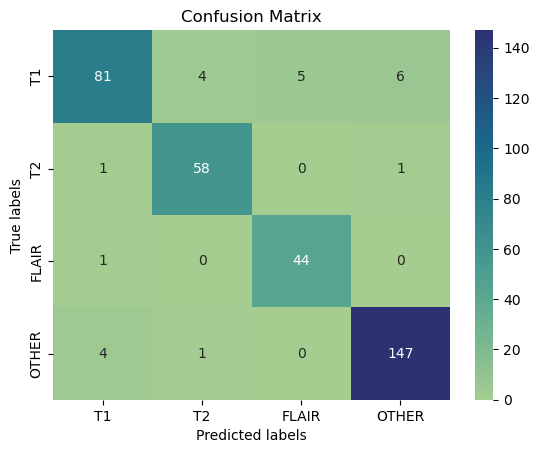

In [22]:
from sklearn.metrics import confusion_matrix 
from seaborn import heatmap
import pandas as pd
confmat_labels = ["T1", "T2" , "FLAIR", "OTHER"]
C_m = confusion_matrix(y_true,y_pred)

ax = plt.subplot()
heatmap(C_m, annot=True, cmap = 'crest', fmt='g', ax=ax); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(confmat_labels);
ax.yaxis.set_ticklabels(confmat_labels);

In [43]:
import pandas as pd 

df = pd.DataFrame(np.array([y_true,y_pred,X_test]).T,columns= ["true", "pred", "name"])

,true,pred,name
0,3.0,3,/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/OTH...
1,2.0,2,/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/FLA...
2,1.0,1,/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/T2/...
3,1.0,1,/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/T2/...
4,1.0,1,/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/T2/...


In [45]:
df.to_csv("../predizioni.csv")

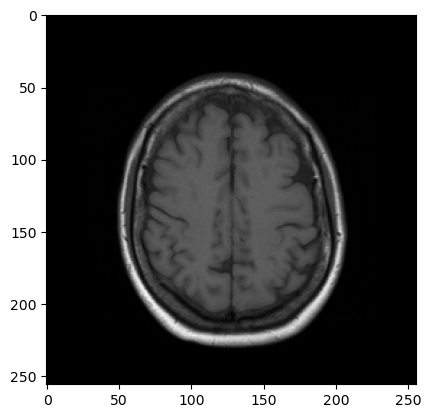

In [51]:
path = "/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/T1/T1W_SE_401_2012020106254223582.npy"
i = np.load(path)
plt.imshow(i[:,:,0],cmap = "gray")